### Modeling Random Forest

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import csv

from sklearn import linear_model
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

import statsmodels.api as sm
#import warnings
#warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.style.use('fivethirtyeight')
np.random.seed(42)

### Gridsearch with Random Forest

GridSearchCV is the modeling technique that searches for the optimal hyperparameters provided during the instantiating of a model. Using its built in cross validation it can search over the grid of the provided hyperparameters to evaluate the performance of each and then use the parameters it found to be the best when making the predictions.

#### Random Forest

This is an ensemble modeling technique that will construct a bunch of random decision trees based on the features and make predictions based on what the model learns about the features the trees are outputting most often. We'll specifically be using Random Forest to predict the discreate variables and in this specific case we will be predicting a binary outcome of whether a post is from Space X (1) or NASA (0).

### Step # 1: Load the Data

With our TfidfVectorizer completed we now have a dataframe that holds the features we want to fit for modeling so I will import this as the features_df variable. Using the weights decided during the Tfidf our model can me the most optimal predictions.

In [2]:
features_df = pd.read_csv('../data/tvec_df.csv')

In [3]:
features_df.head()

,11,12,15,2018,39a,40,air,air force,amp,apollo,...,time,today,twitter,vab,vehicle,video,view,year,years,subreddit
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,spacex
1,0.0,0.0,0.0,0.868537,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,spacex
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,spacex
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.387832,0.0,0.0,0.0,0.0,0.476247,0.0,spacex
4,0.0,0.0,0.0,0.000000,0.0,0.307456,0.0,0.0,0.0,0.0,...,0.304733,0.0,0.267847,0.0,0.0,0.0,0.0,0.000000,0.0,spacex


In [4]:
features_df['subreddit'].value_counts()

nasa      1227
spacex    1221
Name: subreddit, dtype: int64

### Step 2: Setup the X and y

With a final features dataframe for modeling I will setup the X and y variables to be used for training the model for making its final predictions.

In [5]:
features_df['y'] = [1 if i == 'spacex' else 0 for i in features_df['subreddit']]

In [6]:
X = features_df.drop(['subreddit', 'y'], axis=1)
y = features_df['y']

### Step # 3: Train / Test / Split

To perform testing of our model we perform a train, test and split to split our data up into training data for modeling and testing data to verify the accuracy of our model.
- I will use the default split of 75% training data and 25% testing data

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

### Step # 4: Instantiate Model and Setup Parameters

Setting up a variable assigned to the Random Forest model along with the parameters I'd like the GridSearch to search through for the best parameters to be used in the Random Forest model.

In [8]:
rf = RandomForestClassifier()
cross_val_score(rf, X_train, y_train).mean()

0.8921575564008908

In [9]:
params = {
    'n_estimators': [90, 100, 110],
    'criterion': ['gini', 'entropy']
}

### Step # 5: Instantiate the GridSearch

Setting up a variable assigned to the GridSearch model and specifically asking that using Random Forest to search through the identified parameters for the best parameters to be used in the model.

In [10]:
gs = GridSearchCV(rf, param_grid=params)

In [11]:
gs.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [90, 100, 110], 'criterion': ['gini', 'entropy']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [12]:
gs.best_params_

{'criterion': 'entropy', 'n_estimators': 100}

In [13]:
gs.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

#### Interpretation

The Random Forest model is explaining 92.6% of the variance within the model. The other main thing to note is that our testing accuracy is scoring lower than our training accuracy score which means the model is overfit. 

This model is explaining more variance than the KNN model and Logistic Regression model and is arguably the best model that I've built for this data.

In [14]:
gs.score(X_train, y_train)

0.9509803921568627

In [15]:
gs.score(X_test, y_test)

0.9264705882352942

In [16]:
gs.grid_scores_

/Users/nelson/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.89651, std: 0.00320, params: {'criterion': 'gini', 'n_estimators': 90},
 mean: 0.89379, std: 0.00274, params: {'criterion': 'gini', 'n_estimators': 100},
 mean: 0.89651, std: 0.00507, params: {'criterion': 'gini', 'n_estimators': 110},
 mean: 0.89597, std: 0.00200, params: {'criterion': 'entropy', 'n_estimators': 90},
 mean: 0.89760, std: 0.00417, params: {'criterion': 'entropy', 'n_estimators': 100},
 mean: 0.89597, std: 0.00417, params: {'criterion': 'entropy', 'n_estimators': 110}]

### Predictions 

Using a Confusion Matrix I can analze how the LogisticRegression model performed.

When predicting Space X and the subreddit actually being from Space X:
- 296 of my predictions were correct

When predicting Space X and the subreddit actually being from NASA:
- 34 of my predictions said Space X when it was actually form NASA

When predicting NASA and the subreddit actually being from NASA:
- 271 of my predictions were correct

When predicting NASA and the subreddit actually being from Space X:
- 11 of my predictions said Space X when it was actually form NASA

In [17]:
pred_gs = gs.predict(X_test)

In [18]:
con_mat = confusion_matrix(y_test, pred_gs)
con_mat

array([[296,  11],
       [ 34, 271]])

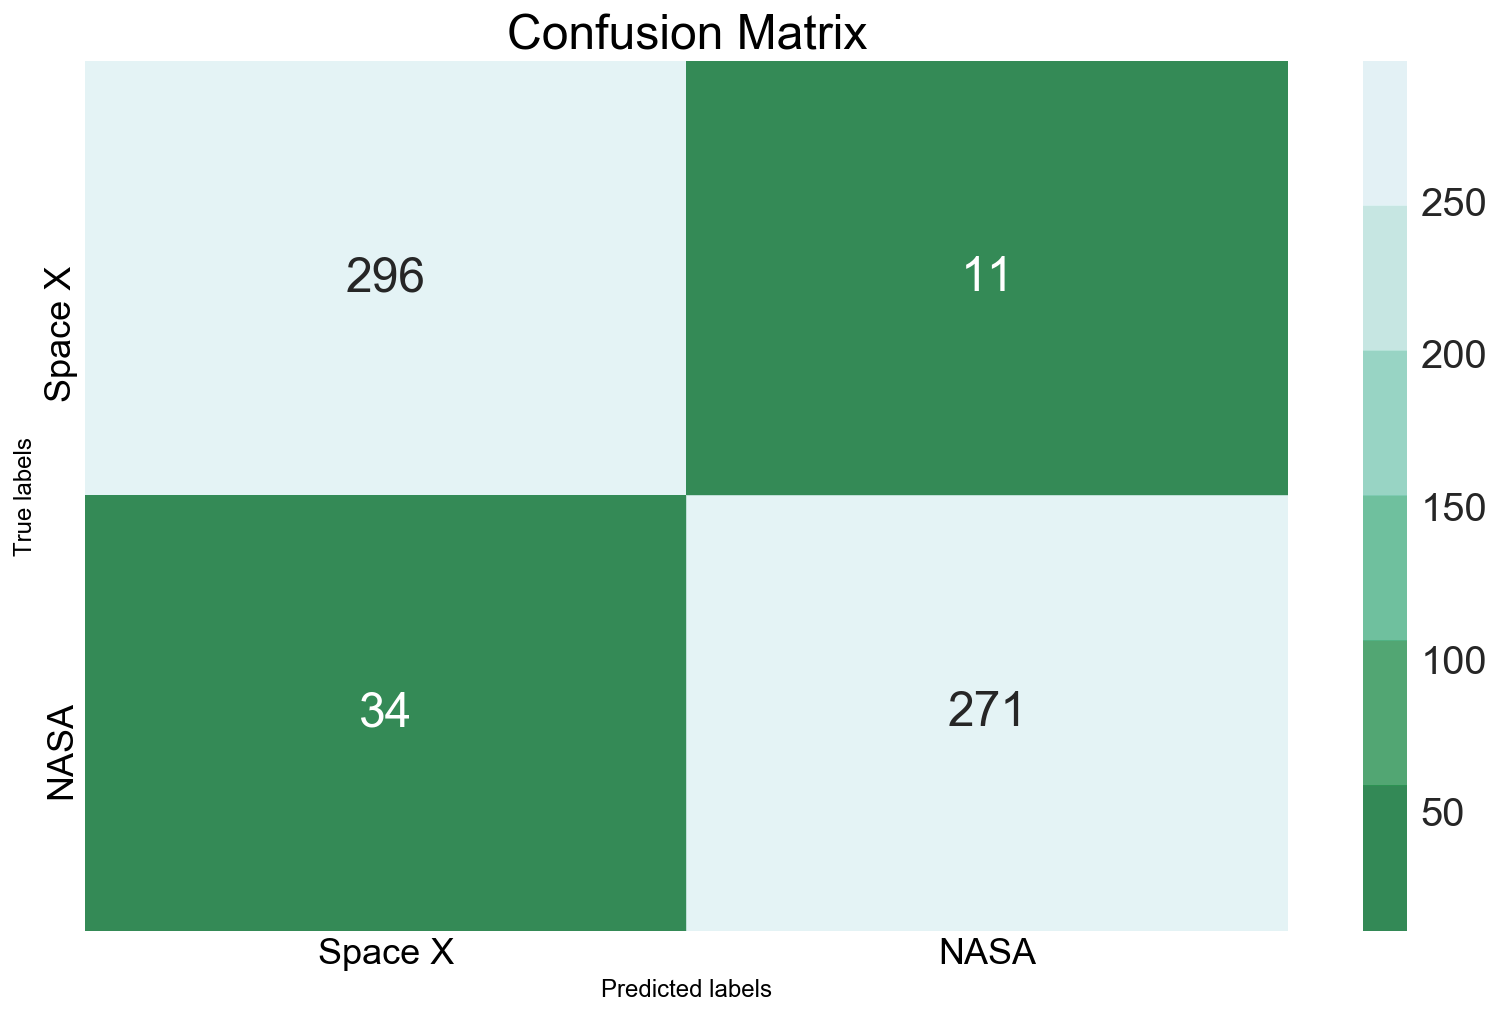

In [19]:
plt.figure(figsize=(12,8))
ax = plt.subplot()
sns.set(font_scale=2)
plt.xticks(fontsize=18); plt.yticks(fontsize=18)
cmap = sns.color_palette("BuGn_r")
sns.heatmap(con_mat, annot=True, cmap=cmap, fmt='g', alpha=.8);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Space X', 'NASA']); 
ax.yaxis.set_ticklabels(['Space X', 'NASA']);
plt.savefig('../plots/cm_random_forest')